In [7]:
include("dependencies.jl")
include("brute_force.jl")

# using ITensors, ITensorMPS, Plots, LaTeXStrings
# using] ProgressMeter
# using Graphs, LinearAlgebra
# using TikzPictures, GraphRecipes
# using HCubature

gr() # or plotly() or pyplot()

function operator_to_vector(op)
    return vec((op)) # op -> transpose(op)
end

function vector_to_operator(vec)
    n = isqrt(length(vec))
    return (reshape(vec, n, n)) # op -> transpose(op)
end


vector_to_operator (generic function with 1 method)

## 2D Ising Stuff

In [8]:
function get_ising_tn(g,N,β;h=0)
    # ising TN with no open indices 
    # g: Graph object
    # N: number of nodes in the graph 
    # β: inverse temp (K_b = 1)
    # J = 1; optional field h
    indmat = [Index(2, "i$(i)j$(j)") for i in 1:N, j in 1:N]
    T = []
    for index = 1:N
        indices = []
        nbrs = neighbors(g, index)
        for nbr in nbrs
            push!(indices,indmat[index,nbr]) ## index --> nbr
        end 
        Ti = ITensor(indices)
        spin = i -> 3 - 2*i ## 1 -> 1, 2 -> -1
        for i1 in 1:2, i2 in 1:2, i3 in 1:2, i4 in 1:2
            s = spin(i1)*spin(i2) + spin(i2)*spin(i3) + spin(i3)*spin(i4) + spin(i4)*spin(i1) 
            s += h*(spin(i1) + spin(i2) + spin(i3) + spin(i4))/2 # divvy by two to avoid double counting
            Ti[i1,i2,i3,i4] = exp(-β * s)
        end 
        # Ti = Ti / norm(Ti) NOT normalizing,
        push!(T,Ti)    
    end 
    return T,indmat
end

function periodic_square_lattice(L::Int)
    g = Graph(L^2)

    # Correct row-major indexing
    idx(i, j) = (i - 1) * L + j
    
    for i in 1:L
        for j in 1:L
            current = idx(i, j)
            right = j < L ? idx(i, j + 1) : idx(i, 1)  # Wrap rightmost to first column
            down = i < L ? idx(i + 1, j) : idx(1, j)    # Wrap bottom to top row
            add_edge!(g, current, right)
            add_edge!(g, current, down)
        end
    end
    return g
end

## analytical free energy, Onsager's solution 

# Define free energy per spin for 2D Ising model with no magnetic field
function free_energy(β::Float64)
    sinh2β = sinh(2 * β)
    cosh2β = cosh(2 * β)
    k = (sinh2β / (cosh2β^2))/2

    integrand(kx, ky) = log(1 - 2 * k * (cos(kx) + cos(ky))) 
    
    integral, _ = hcubature(
        x -> integrand(x[1], x[2]),
        [0.0, 0.0], [π, π],
        rtol=1e-9  # Adjust tolerance for precision
    )
    f = log(2*cosh2β) + integral / (2 * π^2)
    return -f #/β  # multiply by T because f = -T * ( ... )
end



free_energy (generic function with 1 method)

## Sanity check: 2D Ising Phase Transition

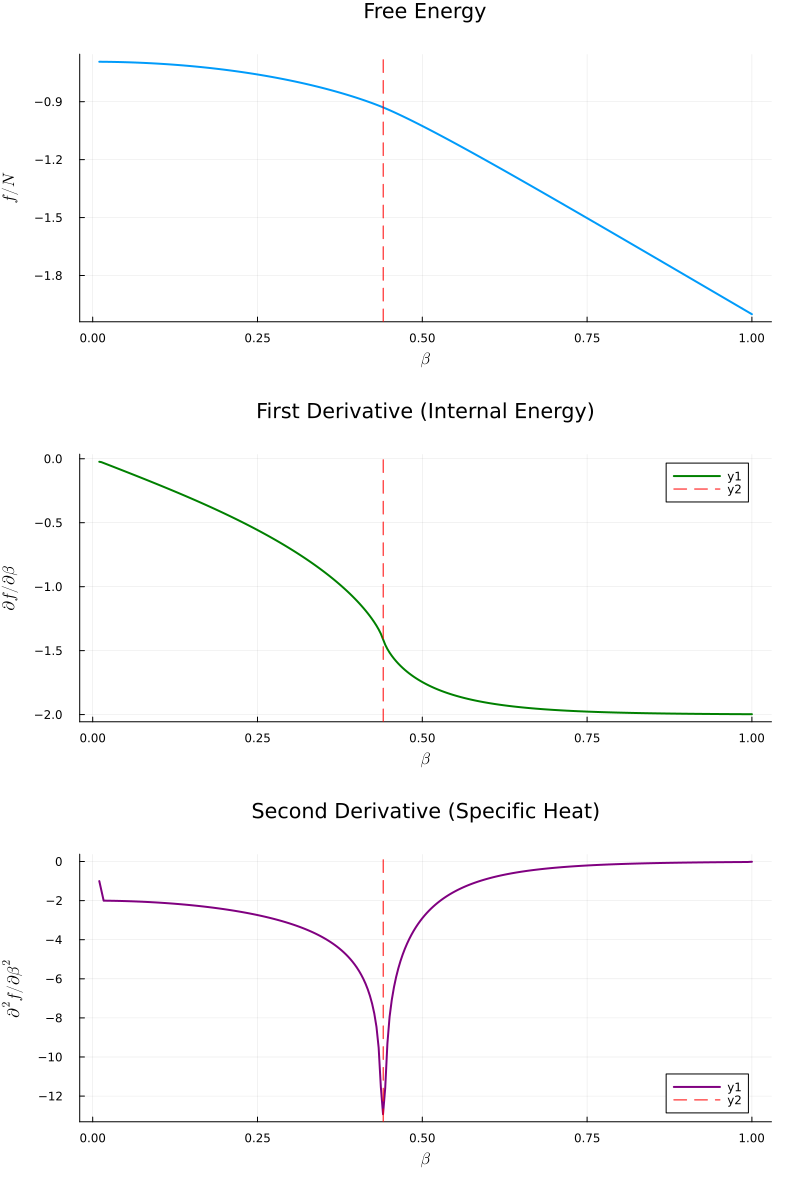

In [9]:
 

function compute_derivatives(βs, fs)
    Δβ = βs[2] - βs[1]  # Assumes uniform spacing
    
    # First derivative using central differences
    dfdβ = [(fs[i+1] - fs[i-1])/(2Δβ) for i in 2:length(fs)-1]
    dfdβ = vcat([(fs[2] - fs[1])/Δβ], dfdβ, [(fs[end] - fs[end-1])/Δβ])
    
    # Second derivative using central differences
    d2fdβ2 = [(dfdβ[i+1] - dfdβ[i-1])/(2Δβ) for i in 2:length(dfdβ)-1]
    d2fdβ2 = vcat([(dfdβ[2] - dfdβ[1])/Δβ], d2fdβ2, [(dfdβ[end] - dfdβ[end-1])/Δβ])
    
    return dfdβ, d2fdβ2
end
β_c=log(1+sqrt(2))/2
βs = range(.01, 1., length=300)
fs = [free_energy(β) for β in βs]
dfdβ, d2fdβ2 = compute_derivatives(βs, fs)
p1 = plot(βs, fs, xlabel=L"\beta", ylabel=L"f/N", 
            title="Free Energy", linewidth=2, legend=false)
            
vline!([β_c], linestyle=:dash, color=:red)

p2 = plot(βs, dfdβ, xlabel=L"\beta", ylabel=L"\partial f/\partial \beta", 
            title="First Derivative (Internal Energy)", color=:green, linewidth=2)
vline!([β_c], linestyle=:dash, color=:red)

p3 = plot(βs, d2fdβ2, xlabel=L"\beta", ylabel=L"\partial^2 f/\partial \beta^2", 
            title="Second Derivative (Specific Heat)", color=:purple, linewidth=2)
vline!([β_c], linestyle=:dash, color=:red)

plot(p1, p2, p3, layout=(3,1), size=(800,1200), margin=5Plots.mm)


## BP Stuff (not Ising specific)

In [10]:
function get_messages(g,indmat,χ,N)
    ## g: Graph 
    ## indmat: matrix of index sets, {index(i,j)}
    ## χ: bond dim 
    ## N: number of nodes
    messages = Array{ITensor}(undef, N, N)
    for v1 in 1:N
        for v2 in 1:N
            if v1 != v2
                index = indmat[v1,v2]
                # define the message FROM v1 TO v2
                messages[v1, v2] = delta(ComplexF64, index) / sqrt(χ) ##  ITensor([1,0],i1) 
            end
        end
    end
    return messages
end 


function message_passing(T,g,messages,indmat)
    ## g: Graph 
    ## indmat: matrix of index sets, {index(i,j)}
    ## T: tensor network 
    ## messages: matrix of message tensors {μ[v1,v2]}
    edge_tuples = [(src(e),dst(e)) for e in edges(g)]
    Δ = 100 
    while Δ > 1e-6
        δ = 0 
        for e in edge_tuples 
            ## want to update the message from v1 → v2 
            v1, v2 = e 
            update = T[v1]
            for nbr in neighbors(g, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1] * delta(indmat[nbr,v1],indmat[v1,nbr])
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end 
        
        # backward
        
        for e in edge_tuples 
            ## want to update the message from v1 → v2 
            v2, v1 = e 
            update = T[v1]
            for nbr in neighbors(g, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1]  * delta(indmat[nbr,v1],indmat[v1,nbr])
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end   
        Δ = δ  
    end 
    return messages 
end 




function mean_free_partition_fn(T,g,messages,indmat,N,these_vertices)
    ## computes the fixed point partition function at the vertices specified by these_vertices 
    ## other things as usual, these_vertices = 1:N gives the BP fixed point
    Z = 1 
    for index = these_vertices
        nbrs = neighbors(g, index)
        Z_local = T[index] 
        for nbr in nbrs
            Z_local *= messages[nbr,index] * delta(indmat[nbr,index],indmat[index,nbr])
        end
        @assert isempty(inds(Z_local))  "T[$index] must be a scalar"
        Z *= scalar(Z_local)
    end
    return Z # -log(Z)/(L^2)
end 


function excited_edge(messages,edge,indmat)
    ## gives the excited projector on the specified edge
    v1,v2 = edge
    # iden = delta(indmat[v1,v2],indmat[v2,v1]) 
    iden = ITensor(indmat[v1,v2],indmat[v2,v1]) 
    for n in 1:dim(indmat[v2,v1])
        iden[indmat[v1,v2]=>n, indmat[v2,v1]=>n] = 1.0 + 0im  # Fill diagonal with ComplexF64 1s
    end
    return iden - messages[v1,v2] * messages[v2,v1]
end 


function loop_contribution(g,loop,messages,T,indmat,N)
    ## gives the excited loop contribution to the partition function at the specified loop, and BP solution at all other edges
    ## loop looks like [(v1,v2),(v2,v3) ...]
    vertices_done = Set()
    loop_contri = 1 
    for edge in loop
        v1, v2 = edge
        loop_contri *= excited_edge(messages,edge,indmat)
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            loop_contri *= T[v1]
            for w in neighbors(g, v1)
                if indmat[v1,w] in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1] * delta(indmat[w,v1],indmat[v1,w])
                end
            end
        end
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            loop_contri *= T[v2]
            for w in neighbors(g, v2)
                if indmat[v2,w] in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2] * delta(indmat[w,v2],indmat[v2,w])
                end
            end
    
        end
    end
    return scalar(loop_contri) * mean_free_partition_fn(T,g,messages,indmat,N,setdiff(Set(1:N),(vertices_done)))
end

loop_contribution (generic function with 1 method)

In [11]:
L = 6
g = periodic_square_lattice(L)
N = L^2 

β = .08
T,indmat = get_ising_tn(g,N,β;h=0.0)
messages = get_messages(g,indmat,2,N)
messages = message_passing(T,g,messages,indmat);
# # mean_free_energy(T,g,messages,N)
print(messages[1,2])

ITensor ord=1
Dim 1: (dim=2|id=310|"i1j2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2-element
 0.7071067811865475 + 0.0im
 0.7071067811865475 + 0.0im

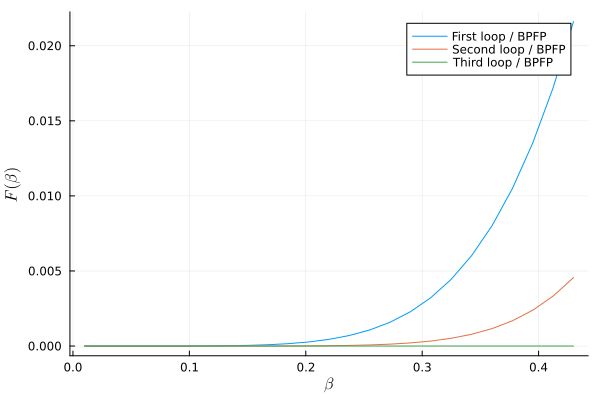

In [11]:
loop1_free_energy = [] 
loop2_free_energy = [] 
loop3_free_energy = []
βs = range(.01, .43 , length=25)
loop1 = [(1,2),(2,8),(7,8),(1,7)]
loop2 = [(1,2),(2,3),(3,9),(9,8),(8,7),(7,1)]
for β in βs
    T,indmat = get_ising_tn(g,N,β;h=0.0)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat)
    Z_mf = mean_free_partition_fn(T,g,messages,indmat,N,Set(1:N)) 
    Z_1loop =  loop_contribution(g,loop1,messages,T,indmat,N) 
    Z_2loop =  loop_contribution(g,loop2,messages,T,indmat,N)
    Z_3loop =  loop_contribution(g,loop3,messages,T,indmat,N)
    push!(loop1_free_energy,Z_1loop./Z_mf )
    push!(loop2_free_energy,Z_2loop./Z_mf )
    push!(loop3_free_energy,Z_3loop./Z_mf )
end
plot(βs, loop1_free_energy, label="First loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop2_free_energy, label="Second loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop3_free_energy, label="Third loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)


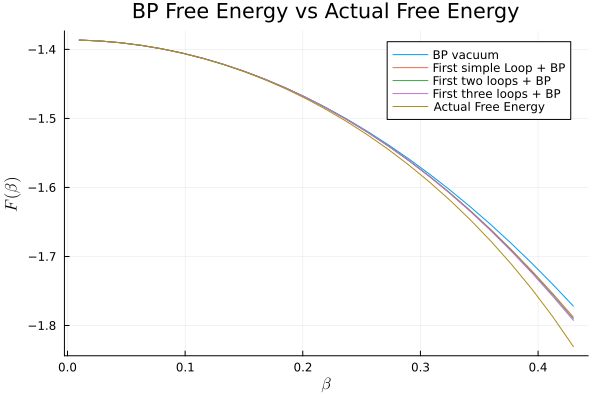

In [8]:
mf_free_energy = [] 
loop1_free_energy = [] 
loop2_free_energy = [] 
loop3_free_energy = []
actual_free_energy = []
loop1 = [(1,2),(2,8),(7,8),(1,7)]
loop2 = [(1,2),(2,3),(3,9),(9,8),(8,7),(7,1)]
loop3 = [(1,2),(2,3),(3,9),(9,8),(8,7),(7,1),(2,8)]
βs = range(.01, .43 , length=25)
for β in βs
    T,indmat = get_ising_tn(g,N,β;h=0.0)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat)
    Z_mf = mean_free_partition_fn(T,g,messages,indmat,N,Set(1:N)) 
    Z_1loop =  N * loop_contribution(g,loop1,messages,T,indmat,N) 
    Z_2loop =  N * loop_contribution(g,loop2,messages,T,indmat,N)
    Z_3loop =  N * loop_contribution(g,loop2,messages,T,indmat,N)
    push!(mf_free_energy,- log(Z_mf)/N)
    push!(loop1_free_energy,- log(Z_mf + Z_1loop)/N )
    push!(loop2_free_energy,- log(Z_mf + Z_1loop + Z_2loop)/N )
    push!(loop3_free_energy,- log(Z_mf + Z_1loop + Z_2loop + Z_3loop)/N)
    push!(actual_free_energy,free_energy(β) * 2)
end
plot(βs, mf_free_energy, label="BP vacuum", xlabel=L"β", ylabel=L"F(β)", title="BP Free Energy vs Actual Free Energy", legend=:topright)
plot!(βs, loop1_free_energy, label="First simple Loop + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop2_free_energy, label="First two loops + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop3_free_energy, label="First three loops + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, actual_free_energy, label="Actual Free Energy", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
# β_c=log(1+sqrt(2))/2
# vline!([β_c], linestyle=:dash, color=:red,label=L"\beta_c")

